First, import some useful packages and set everything up.

In [ ]:
%matplotlib inline
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import seaborn
import torch
import torch.nn as nn
import unittest

def set_seed(seed):  # For reproducibility, fix random seeds.
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

set_seed(42)

# Transformer Encoder-Decoder

In this assignment we will implement the Transformer encoder-decoder model proposed in [Attention is All You Need (Vaswani et al., 2017)](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) from scratch. There are multiple components to this model. At a high-level, we need to implement the following.

<p align="center">
<img src='https://drive.google.com/uc?id=1bTYE71w6mU2fwIGOc0MLdagySvbL8cIs' width="300">
</p>

1. **Multi-head attention**: Gets query, key, value embeddings and outputs new embeddings (same length as the given query sequence) by splitting them with "heads" and attending within each head. Used for self-attention in the encoder, and both self-attention and cross-attention in the decoder, at every layer.
2. **Position embeddings**: Attention alone does not provide any information about token positions, so we need to encode them somehow. We will follow the simple approach in the original paper where we "position" token embeddings by adding constant (i.e., not learnable) embeddings that are distinct for different positions.
3. **Encoder layer**: Each encoder layer receives source embeddings (initially just token embeddings plus position embeddings) and applies a sequence of self-attention, layer normalization, dropout, and nonlinear feedforward transformation in some order. The **encoder** module consists of $L$ ($N$ in the figure) such layers, continuously performing self-attention over previously transformed source embeddings.
4. **Decoder layer**: Each decoder layer receives the final source embeddings of the encoder module and $t-1$ target embeddings in history so far, then applies a sequence of self-attention over target embeddings and cross-attention between target embeddings and source embeddings, along with other transformations similarly as in the encoder layer. The **decoder** module consists of $L$ such layers, continuously performing self-attention over previously transformed target embeddings and cross-attention with the final source embeddings.
5. **Label-smoothing loss**: Instead of treating next word as the sole correct label, assign some nonzero uniform probabilities to all words, as a way of regularization.
6. **Encoder-decoder**: This top module simply wraps the encoder and the decoder modules along with a linear layer $\mathbb{R}^d \rightarrow \mathbb{R}^V$ to compute next word probabilities. The entire model is trained by minimizing the (conditional) per-token cross-entropy loss $J(\theta) = \textbf{E}[-\log p_\theta(y_t|x, y_1 \ldots y_{t-1})]$ (with optional label smoothing).
7. **Decoding algorithms**: Once the model is trained by cross entropy minimization on source-target sequence pairs, we need a decoding function that takes the trained model and a source sequence then returns a target sequence. As we discussed in class, this search problem is intractable so we will use **beam search** for approximation.

It's all conceptually straightforward, but there are too many important details that cannot be understood until we implement the model (e.g., how to parallelize training with masked attention). So let's begin.

## Attention

We will first implement the scaled dot product, which computes the score of a specific query-key pair $q, k \in \mathbb{R}^d$ by:
$$
(q, k) \mapsto \frac{q^\top k}{\sqrt{d}}
$$
And we will implement this in batch, meaning
$$\begin{align*}
(q_1 \ldots q_{T'}, k_1 \ldots k_T) \mapsto S \in \mathbb{R}^{T' \times T} && [S]_{t', t} = \frac{q_{t'}^\top k_t}{\sqrt{d}}
\end{align*}$$
Here's a cool trick: the input tensors can have arbitrarily many dimensions as long as (1) the final dimension is the embedding dimension, and (2) the pen-ultimate dimension is the length. This will be useful when we do multi-head attention where we split vectors into multiple parts. Also, we will have an option of  <font color="red">masking</font> certain keys, which will be crucial in parallelizing training. The mask will be provided in the form of a matrix $M \in \{\mathrm{TRUE},\mathrm{FALSE}\}^{T' \times T}$ where $[M]_{t' \times t}$ is true iff query $q_{t'}$ ignores key $k_t$.

In [ ]:
def scaled_dot(query, key, mask_key=None):
  score = torch.matmul(query, key.transpose(-2, -1))
  score /= math.sqrt(query.size(-1))
  if mask_key is not None:
    score = score.masked_fill(mask_key, -1e18)  # Represents negative infinity
  return score

Another cool thing is that we can provide mask $M$ with dimensions $1 \times T$ to mean that all $T'$ queries share the same mask, instead of each query having separate masks.

In [ ]:
query = torch.randn(3, 10)
key = torch.randn(5, 10)

mask_key = torch.BoolTensor([[0, 0, 0, 1, 1]])
score = scaled_dot(query, key, mask_key=mask_key)
print(score, '\n')

mask_key = torch.BoolTensor([[0, 0, 1, 1, 1],
                             [0, 0, 0, 1, 1],
                             [0, 0, 0, 0, 1]])
score = scaled_dot(query, key, mask_key=mask_key)
print(score)

tensor([[-1.7802e+00, -1.7370e+00,  1.9773e+00, -1.0000e+18, -1.0000e+18],
        [-1.8871e-01, -1.2220e-01, -9.1524e-03, -1.0000e+18, -1.0000e+18],
        [-1.5998e-01,  2.6194e-01,  2.3366e-01, -1.0000e+18, -1.0000e+18]]) 

tensor([[-1.7802e+00, -1.7370e+00, -1.0000e+18, -1.0000e+18, -1.0000e+18],
        [-1.8871e-01, -1.2220e-01, -9.1524e-03, -1.0000e+18, -1.0000e+18],
        [-1.5998e-01,  2.6194e-01,  2.3366e-01,  1.5326e+00, -1.0000e+18]])


We will now implement general attention. Given

- query: Last two dimensions $(T', d)$
- key: Last two dimensions $(T, d)$
- value: Last two dimensions $(T, d_v)$

compute

- answer: Last two dimensions $(T', d_v)$
- attention: Last two dimensions $(T', T)$

We will also do attention dropout, meaning *after* computing softmax we apply a dropout layer on probabilities (if not None). This may make the softmax output an invalid distribution, but is found helpful as regularization.

In [ ]:
def attend(query, key, value, mask_key=None, dropout=None):
  score = scaled_dot(query, key, mask_key = mask_key)  # Use scaled_dot, be sure to mask key
  attention = torch.nn.functional.softmax(score, dim = -1) # applying softmax
  if dropout is not None:
      attention = dropout(attention)
  answer = torch.matmul(attention, value)  # Convexly combine value embeddings using attention, this should be just a matrix-matrix multiplication.
  return answer, attention

In [ ]:
class TestAttention(unittest.TestCase):

  def setUp(self):
    self.query = torch.FloatTensor([[1, 2, 1],
                                    [2, 1, 2]])
    self.key = torch.FloatTensor([[1, 1, 1],
                                  [0.9, 0.8, 0.8],
                                  [1.1, 1.2, 0.9]])
    self.value = torch.FloatTensor([[16, 17],
                                    [18, 19],
                                    [20, 21]])
    self.mask_key = torch.BoolTensor([[0, 0, 1],
                                      [0, 0, 0]])
    self.places = 4

  def test_attend(self):
    answer, attention = attend(self.query, self.key, self.value, self.mask_key)
    self.assertAlmostEqual(answer[0, 0].item(), 16.8006, places=self.places)
    self.assertAlmostEqual(answer[0, 1].item(), 17.8006, places=self.places)
    self.assertAlmostEqual(answer[1, 0].item(), 18.0889, places=self.places)
    self.assertAlmostEqual(answer[1, 1].item(), 19.0889, places=self.places)
    self.assertAlmostEqual(attention[0, 0].item(), 0.5997, places=self.places)
    self.assertAlmostEqual(attention[0, 1].item(), 0.4003, places=self.places)
    self.assertAlmostEqual(attention[0, 2].item(), 0.0000, places=self.places)
    self.assertAlmostEqual(attention[1, 0].item(), 0.3633, places=self.places)
    self.assertAlmostEqual(attention[1, 1].item(), 0.2289, places=self.places)
    self.assertAlmostEqual(attention[1, 2].item(), 0.4078, places=self.places)

unittest.main(TestAttention(), argv=[''], verbosity=2, exit=False)

test_attend (__main__.TestAttention) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.014s

OK


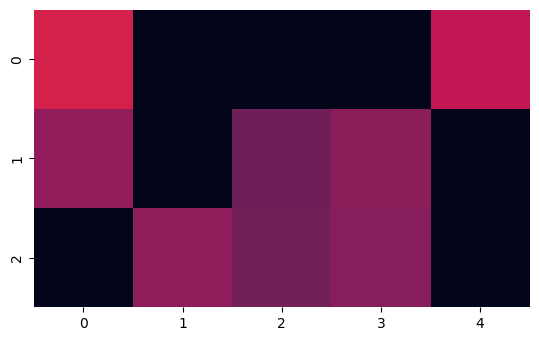

In [ ]:
def draw_attention(attention, x, y, ax=None):  # attention: matrix with probabilities as elements
  seaborn.heatmap(attention, xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, cbar=False, ax=ax)

query = torch.rand(3, 10)  # Positive values for better visualization
key = torch.rand(5, 10)
mask_key = torch.BoolTensor([[0, 1, 1, 1, 0],
                             [0, 1, 0, 0, 1],
                             [1, 0, 0, 0, 1]])
answer, attention = attend(query, key, key, mask_key)
draw_attention(attention, list(range(key.size(0))), list(range(query.size(0))))

Finally let's implement multi-head attention. This is now a module with learnable parameters. First we will define some helper functions for splitting and merging vectors efficiently. In particular, splitting incurs no new memory allocation, because we simply reshape tensors.

In [ ]:
def split_heads(batch, num_heads):
  (batch_size, length, dim) = batch.size()  # These are the expected batch dimensions.
  assert dim % num_heads == 0  # Assert that dimension is divisible by the number of heads.
  dim_head = dim // num_heads

  # No new memory allocation
  splitted = batch.view(batch_size, -1, num_heads, dim_head).transpose(1, 2)
  return splitted  # (batch_size, num_heads, length, dim_head), note that now the last two dimensions are compatible with our attention functions.

In [ ]:
def merge_heads(batch):
  (batch_size, num_heads, length, dim_head) = batch.size()  # These are the expected batch dimensions.

  # New memory allocation (reshape), can't avoid.
  merged = batch.transpose(1, 2).reshape(batch_size, -1, num_heads * dim_head)
  return merged  # (batch_size, length, dim)

In [ ]:
batch = torch.randn(1, 2, 3)
print('batch', tuple(batch.size()), '-- 2 embeddings of dimension 3')
print(batch)
splitted = split_heads(batch, 3)
print('\nsplitted', tuple(splitted.size()), '-- 3 heads, for each 2 embeddings of dimension 1')
print(splitted)
merged = merge_heads(splitted)
print('\nmerged', tuple(merged.size()))
print(merged)

batch (1, 2, 3) -- 2 embeddings of dimension 3
tensor([[[-1.2753, -0.4758,  2.3839],
         [ 0.9157, -0.6430,  0.7113]]])

splitted (1, 3, 2, 1) -- 3 heads, for each 2 embeddings of dimension 1
tensor([[[[-1.2753],
          [ 0.9157]],

         [[-0.4758],
          [-0.6430]],

         [[ 2.3839],
          [ 0.7113]]]])

merged (1, 2, 3)
tensor([[[-1.2753, -0.4758,  2.3839],
         [ 0.9157, -0.6430,  0.7113]]])


The multi-head attention module has a learnable linear layer to transform input for each query/key/value before splitting. As a result, even if we tie inputs (i.e., self-attention) they'll be first "specialized" to perform different roles.

The forward function has two modes:

1. Training: Expects arbitrary query length.
2. Stepwise decoding: Expects query length 1.

The reason we make this distinction is that in stepwise decoding we provide one query at a time (i.e., the very last token we predicted, or \<bos\>), and **we shouldn't recompute past key and value vectors**. So we'll expect a cache that provides these values.

We must make one last distinction: is this self-attention or cross-attention? This information is needed only for decoding. We need this because we need to use different key/value caches.

- If self-attention, key/value caches are from previous target tokens.
- If cross-attention, key/value caches are from source tokens.  

But in either case, we assume that the cache contains these embeddings. Note that because Trasformer has multiple layers each with its own multi-head attention module, we will need a separate cache for each layer. This is why we call the cache "layer_cache" below.

In [ ]:
class MultiHeadAttention(nn.Module):

  def __init__(self, dim, num_heads, dropout_rate=0.1):
    super().__init__()
    assert dim % num_heads == 0

    self.linear_query = nn.Linear(dim, dim)
    self.linear_key = nn.Linear(dim, dim)
    self.linear_value = nn.Linear(dim, dim)
    self.linear_final = nn.Linear(dim, dim)
    self.dropout = nn.Dropout(dropout_rate)

    self.num_heads = num_heads

  def forward(self, query, key, value, mask_key=None, layer_cache=None,
              memory_attention=False):
    """
    INPUT
      query: (batch_size, length_query, dim)
      key: (batch_size, length_key, dim)
      value: (batch_size, length_key, dim_value)
      mask_key: (*, 1, length_key) if queries share the same mask, else
                (*, length_query, length_key)
      layer_cache: if not None, stepwise decoding (cache of key/value)
      memory_attention: doing memory attention in stepwise decoding?
    OUTPUT
      answer: (batch_size, length_query, dim_value)
      attention: (batch_size, num_heads, length_query, length_key) else
    """
    batch_size = query.size(0)

    query = self.linear_query(query)
    query = split_heads(query, self.num_heads)  # (batch_size, num_heads, -1, dim_head)

    def process_key_value(key, value):  # Only called when necessary.
      key = self.linear_key(key)
      key = split_heads(key, self.num_heads)
      value = self.linear_value(value)
      value = split_heads(value, self.num_heads)
      return key, value

    if layer_cache is None:
      key, value = process_key_value(key, value)
    else:
      assert query.size(2) == 1  # Stepwise decoding

      if memory_attention:
        if layer_cache['memory_key'] is None:  # One-time calculation
          key, value = process_key_value(key, value)

          # (batch_size, num_heads, length_memory, dim)
          layer_cache['memory_key'] = key
          layer_cache['memory_value'] = value

        key = layer_cache['memory_key']
        value = layer_cache['memory_value']

      else:  # Self-attention during decoding
        key, value = process_key_value(key, value)
        assert key.size(2) == 1 and value.size(2) == 1

        # Append to previous.
        if layer_cache['self_key'] is not None:
          key = torch.cat((layer_cache['self_key'], key), dim=2)
          value = torch.cat((layer_cache['self_value'], value), dim=2)

        # (batch_size, num_heads, length_decoded, dim)
        layer_cache['self_key'] = key  # Recache.
        layer_cache['self_value'] = value

    # Because we've splitted embeddings into heads, we must also split the mask.
    # And because each query uses the same mask for all heads (we don't use different masking for different heads),
    # we can specify length 1 for the head dimension.
    if mask_key is not None:
      mask_key = mask_key.unsqueeze(1)  # (batch_size, 1, -1, length_key)

    answer, attention = attend(query, key, value, mask_key, self.dropout)

    answer = merge_heads(answer)  # (batch_size, length_key, dim)
    answer = self.linear_final(answer)

    return answer, attention

### Training Illustration

Before we go any further, let's understand how multi-head attention will be used in each layer inside Transformer. At training time, assuming target sequence $y_1 \ldots y_{T'}$, we will have $T' + 1$ prediction problems (predict $y_1$ from \<bos\>, ..., predict \<eos\> from \<bos\>, $y_1$, ..., $y_{T'}$). For each of these positions where we make predictions, $0, 1, \ldots, T'$, we will **mask future positions** like $(1, \ldots, T')$ for $0$, $(2, \ldots, T')$ for $1$, etc.

In [ ]:
def get_mask_future(num_positions):
  return torch.triu(torch.ones(1, num_positions, num_positions), diagonal=1) == 1

In [ ]:
get_mask_future(5)

tensor([[[False,  True,  True,  True,  True],
         [False, False,  True,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False, False,  True],
         [False, False, False, False, False]]])

During training, we don't need to provide any layer cache. So self-attention on the encoder side will look like this.

In [ ]:
source = torch.randn(1, 2, 2)  # 2 embs, 2 dims each
attn_enc_layer = MultiHeadAttention(2, 2, dropout_rate=0)  # 2 heads, 1 dim each
answer, _ = attn_enc_layer(source, source, source)  # No need to mask future

Self-attention on the decoder side will look like this.

In [ ]:
target = torch.randn(1, 3, 2)  # 3 embs, 2 dims each. Last emb is predicting <eos>.
attn_dec_layer = MultiHeadAttention(2, 2, dropout_rate=0)  # 3 heads, 1 dim each
mask = get_mask_future(3)
answer, attention = attn_dec_layer(target, target, target, mask)  # Mask (2, 3), (3), () for the three positions.
print(attention)  # *Each* of the 2 heads will have its own 3 x 3 attention map, appropriately masked.

tensor([[[[1.0000, 0.0000, 0.0000],
          [0.5310, 0.4690, 0.0000],
          [0.3330, 0.3914, 0.2757]],

         [[1.0000, 0.0000, 0.0000],
          [0.5020, 0.4980, 0.0000],
          [0.1898, 0.3055, 0.5047]]]], grad_fn=<SoftmaxBackward0>)


Cross-attention on the decoder side will look like this.

In [ ]:
answer, attention = attn_dec_layer(target, source, source)  # Note target is querying source now, no future mask needed.

### Stepwise Decoding Illustration

We indicate that this is decoding by passing an empty cache (not None), initially empty. It'll be filled by computing values only once, and then next time retrieving them instead of recomputing.

In [ ]:
def print_cache(cache):
  for k, v in cache.items():
    if v is not None:
      print(k, tuple(v.size()))

layer_cache = {'memory_key': None, 'memory_value': None, 'self_key': None, 'self_value': None}
print('Initial cache:')
print_cache(layer_cache)
target0 = torch.randn(1, 1, 2)  # <bos> emb
attn_dec_layer(target0, target0, target0, layer_cache=layer_cache)  # Decoder self-attention
print('\nCache after self-attention in prediction from <bos>:')
print_cache(layer_cache)
attn_dec_layer(target0, source, source, layer_cache=layer_cache, memory_attention=True)  # Decoder cross-attention
print('\nCache after cross-attention in prediction from <bos>:')
print_cache(layer_cache)
target1 = torch.randn(1, 1, 2)  # Emb of first predicted token
attn_dec_layer(target1, target1, target1, layer_cache=layer_cache)  # Decoder self-attention
print('\nCache after self-attention in prediction from y1 (note we have expanded self key/value cache):')
print_cache(layer_cache)
attn_dec_layer(target1, source, source, layer_cache=layer_cache, memory_attention=True)  # Decoder cross-attention
print('\nCache after cross-attention in prediction from y1:')
print_cache(layer_cache)


Initial cache:

Cache after self-attention in prediction from <bos>:
self_key (1, 2, 1, 1)
self_value (1, 2, 1, 1)

Cache after cross-attention in prediction from <bos>:
memory_key (1, 2, 2, 1)
memory_value (1, 2, 2, 1)
self_key (1, 2, 1, 1)
self_value (1, 2, 1, 1)

Cache after self-attention in prediction from y1 (note we have expanded self key/value cache):
memory_key (1, 2, 2, 1)
memory_value (1, 2, 2, 1)
self_key (1, 2, 2, 1)
self_value (1, 2, 2, 1)

Cache after cross-attention in prediction from y1:
memory_key (1, 2, 2, 1)
memory_value (1, 2, 2, 1)
self_key (1, 2, 2, 1)
self_value (1, 2, 2, 1)


## Position Embeddings

We will define a module that will take initial token embeddings and "position" them by adding constant vectors (among other things). The original Transformer paper proposed defining these constant vectors by [sinusoidal waveforms](https://en.wikipedia.org/wiki/Sine_wave) (i.e., sine and cosine values) because they will give us distinct embeddings for all positions. There's a reason for the specific choice of frequencies they use. In their words: "The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$".

We will not dwell on the deatils too much, however, since it's become more common to model *relative* positions. See [this paper](https://arxiv.org/pdf/1803.02155.pdf). The idea there is that *absolute* position encodings are not useful for large $t$, so it's better to model relative distances (as edge weights of a graph).

One gotcha here is that we must again specify whether this is training or stepwise decoding, because if stepwise decoding we must use look up the correct position embedding.

In [ ]:
class SinusoidalPositioner(nn.Module):

  def __init__(self, dim, drop_rate=0.1, length_max=5000):
    super().__init__()
    frequency = torch.exp(torch.arange(0, dim, 2) * -(math.log(10000.) / dim))  # Using different frequency for each dim
    positions = torch.arange(0, length_max).unsqueeze(1)
    wave = torch.zeros(length_max, dim)
    wave[:, 0::2] = torch.sin(frequency * positions)
    wave[:, 1::2] = torch.cos(frequency * positions)
    self.register_buffer('wave', wave.unsqueeze(0))  # (1, length_max, dim)
    self.dropout = nn.Dropout(drop_rate)
    self.dim = dim
    self.length_max = length_max

  def forward(self, x, step=-1):
    assert x.size(-2) <= self.length_max

    if step < 0:  # Take the corresponding leftmost embeddings.
      position_encoding = self.wave[:, :x.size(-2), :]
    else:  # Take the embedding at the step.
      position_encoding = self.wave[:, step, :]

    x = x * math.sqrt(self.dim)
    return self.dropout(x + position_encoding)

positioner = SinusoidalPositioner(4, drop_rate=0., length_max=5)

Precomputed 100 position embeddings of dim 10, first few:
tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  1.5783e-01,  9.8747e-01,  2.5116e-02,
          9.9968e-01,  3.9811e-03,  9.9999e-01,  6.3096e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  3.1170e-01,  9.5018e-01,  5.0217e-02,
          9.9874e-01,  7.9621e-03,  9.9997e-01,  1.2619e-03,  1.0000e+00],
        [ 1.4112e-01, -9.8999e-01,  4.5775e-01,  8.8908e-01,  7.5285e-02,
          9.9716e-01,  1.1943e-02,  9.9993e-01,  1.8929e-03,  1.0000e+00],
        [-7.5680e-01, -6.5364e-01,  5.9234e-01,  8.0569e-01,  1.0031e-01,
          9.9496e-01,  1.5924e-02,  9.9987e-01,  2.5238e-03,  1.0000e+00]])


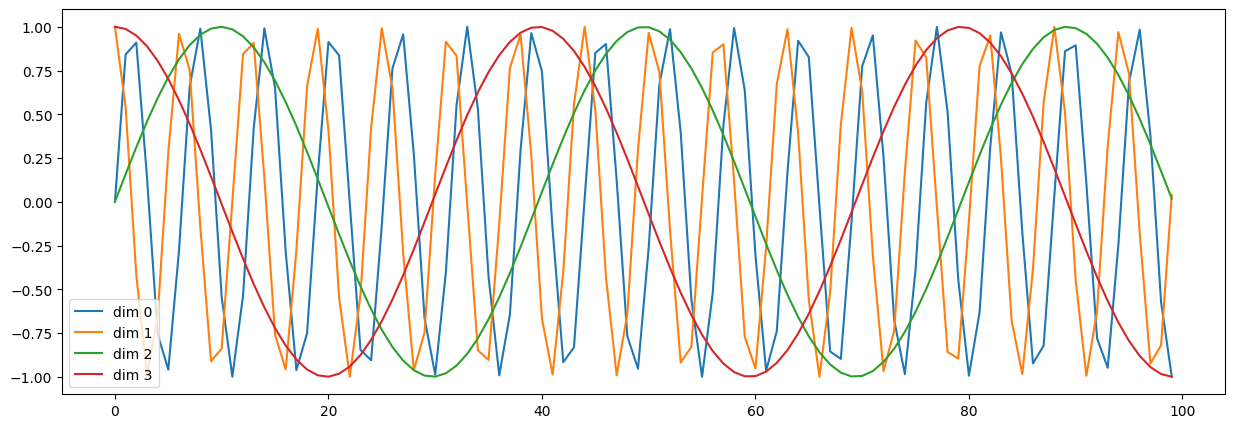

In [ ]:
dim = 10
length_max = 100
positioner = SinusoidalPositioner(dim, drop_rate=0., length_max=length_max)
print('Precomputed %d position embeddings of dim %d, first few:' % (length_max, positioner.dim))
print(positioner.wave[0, 0:5, :])
plt.figure(figsize=(15, 5))
plt.plot(np.arange(length_max), positioner.wave[0, :, 0:4].data.numpy())
plt.legend(["dim %d"%p for p in [0,1,2,3]])

positioned_embeddings = positioner(torch.randn(1, 3, dim))  # Training use case
positioned_embedding = positioner(torch.randn(1, 1, dim), step=0)  # Inference use case

Note how offsets are different for even vs odd dimensions, and within each even or odd dimensions how frequencies are different. The position embeddings can alternatively be learned as part of model, but they didn't find much difference and this has the benefit of having fewer parameters to learn.

## Encoder

We're almost ready to define the encoder. Now that we have the most important building block of multi-head attention, it's pretty straightforward. The Transformer layer additionally uses a typically quite large nonlinear layer, so let's define that first. Importantly, within each layer, **the same nonlinear layer is applied for all positions**. This parameter sharing is what enables Transformer to handle arbitrary lengths.

In [ ]:
class PositionwiseFeedForward(nn.Module):

  def __init__(self, dim, dim_hidden, drop_rate=0.1):
    super().__init__()
    self.w1 = nn.Linear(dim, dim_hidden)
    self.w2 = nn.Linear(dim_hidden, dim)
    self.layer_norm = nn.LayerNorm(dim, eps=1e-6)
    self.drop1 = nn.Dropout(drop_rate)
    self.relu = nn.ReLU()
    self.drop2 = nn.Dropout(drop_rate)

  def forward(self, x):
    inter = self.drop1(self.relu(self.w1(self.layer_norm(x))))
    output = self.drop2(self.w2(inter))
    return output + x

As mentioned earlier, each encoder layer uses some combination of feedforward, [layer normalization](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html), dropout, and most importantly multi-head self-attention, along with residual connection to pass along information before computing attention. We will not follow the original paper and apply layer norm first, which is rumored to be a bit more effective. We also pass along a mask. We need a mask even on the source side, because we will be padding source sequence of different lengths and want to ignore padded positions when self-attending.

In [ ]:
class TransformerEncoderLayer(nn.Module):

  def __init__(self, dim, num_heads, dim_hidden, drop_rate):
    super().__init__()
    self.layer_norm = nn.LayerNorm(dim, eps=1e-6)
    self.self_attention = MultiHeadAttention(dim, num_heads, drop_rate)
    self.drop = nn.Dropout(drop_rate)
    self.feedforward = PositionwiseFeedForward(dim, dim_hidden, drop_rate)

  def forward(self, source, mask_source=None):
    normed = self.layer_norm(source)  # Apply layer norm on source
    attended, attention = self.self_attention(normed, normed, normed, mask_key = mask_source) # Apply self-attention on normed (be sure to use mask_source).
    attended = self.drop(attended) + source  # Re-write attended by applying dropout and adding a residual connection to source.
    return self.feedforward(attended), attention

In [ ]:
class TestTransformerEncoderLayer(unittest.TestCase):

  def setUp(self):
    set_seed(42)
    self.encoder_layer = TransformerEncoderLayer(10, 2, 20, 0.1)
    self.source = torch.randn(5, 7, 10)
    self.mask = torch.FloatTensor(5, 1, 7).uniform_() > 0.5
    self.places = 4

  def test_forward(self):
    output, attention = self.encoder_layer(self.source, mask_source=self.mask)
    self.assertEqual(tuple(output.size()), (5, 7, 10))
    self.assertEqual(tuple(attention.size()), (5, 2, 7, 7))
    self.assertAlmostEqual(output[0, 0, 0].item(), 0.2916, places=self.places)
    self.assertAlmostEqual(attention[0, 0, 0, 0].item(), 0.4997, places=self.places)

unittest.main(TestTransformerEncoderLayer(), argv=[''], verbosity=2, exit=False)

test_forward (__main__.TestTransformerEncoderLayer) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.030s

OK


The encoder module is simply a stack of encoder layers, which will autoregressively apply self-attention and residual transformation over and over again.

In [ ]:
class TransformerEncoder(nn.Module):

  def __init__(self, dim, num_heads, dim_hidden, drop_rate, num_layers):
    super().__init__()
    self.layers = nn.ModuleList([TransformerEncoderLayer(dim, num_heads, dim_hidden, drop_rate) for _ in range(num_layers)])
    self.layer_norm = nn.LayerNorm(dim, eps=1e-6)

  def forward(self, source, mask_source=None):
    out = source
    self_attentions = []
    for layer in self.layers:
      out, attention = layer(out, mask_source)
      self_attentions.append(attention)
    return self.layer_norm(out), self_attentions

In [ ]:
encoder = TransformerEncoder(100, 5, 200, 0.1, 2)  # Encoder with 2 layers, 5 heads of dim 20, hidden dim 200
print(encoder)

TransformerEncoder(
  (layers): ModuleList(
    (0-1): 2 x TransformerEncoderLayer(
      (layer_norm): LayerNorm((100,), eps=1e-06, elementwise_affine=True)
      (self_attention): MultiHeadAttention(
        (linear_query): Linear(in_features=100, out_features=100, bias=True)
        (linear_key): Linear(in_features=100, out_features=100, bias=True)
        (linear_value): Linear(in_features=100, out_features=100, bias=True)
        (linear_final): Linear(in_features=100, out_features=100, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (drop): Dropout(p=0.1, inplace=False)
      (feedforward): PositionwiseFeedForward(
        (w1): Linear(in_features=100, out_features=200, bias=True)
        (w2): Linear(in_features=200, out_features=100, bias=True)
        (layer_norm): LayerNorm((100,), eps=1e-06, elementwise_affine=True)
        (drop1): Dropout(p=0.1, inplace=False)
        (relu): ReLU()
        (drop2): Dropout(p=0.1, inplace=False)
      )
    )
  )


## Decoder

The decoder layer is pretty similar as the encoder layer, meaning it applies attention and residual transformations, except that we have a distinction between self-attention and **cross-attention**. It performs both, so that it captures information from previous targets and also from the source sequence that it conditions on. But they will have separate multi-head attention modules (i.e., separate parameters to learn).

We also pass along a layer cache, to be used in each multi-head attention module during stepwise decoding (if not None). We pass along masks for both source (for padding) and target (for future positions during training).

In [ ]:
class TransformerDecoderLayer(nn.Module):

  def __init__(self, dim, num_heads, dim_hidden, drop_rate):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(dim, eps=1e-6)
    self.self_attention = MultiHeadAttention(dim, num_heads, drop_rate)
    self.drop = nn.Dropout(drop_rate)
    self.layer_norm2 = nn.LayerNorm(dim, eps=1e-6)
    self.context_attention = MultiHeadAttention(dim, num_heads, drop_rate)
    self.feedforward = PositionwiseFeedForward(dim, dim_hidden, drop_rate)

  def forward(self, target, memory, mask_target, mask_source, layer_cache=None):
    normed = self.layer_norm1(target)  # Apply layer_norm1 to target.
    query, self_attention = self.self_attention(normed, normed, normed, mask_key = mask_target, layer_cache = layer_cache, memory_attention = False) # Apply self-attention on normed (be sure to use mask_target, layer_cache, and set memory_attention correctly).

    query = self.drop(query) + target  # Re-write query by applying dropout and adding a residual connection to target.
    attended, cross_attention = self.context_attention(self.layer_norm2(query), memory, memory, mask_key = mask_source, layer_cache = layer_cache, memory_attention = True) # Apply cross-attention using **layer_norm2(query)** as query and **memory** as key/value (be sure to use mask_source, layer_cache, and set memory_attention correctly).
    attended = self.drop(attended) + query  # Re-write attended by applying dropout and adding a residual connection to query.
    return self.feedforward(attended), self_attention, cross_attention

In [ ]:
class TestTransformerDecoderLayer(unittest.TestCase):

  def setUp(self):
    set_seed(42)
    self.decoder_layer = TransformerDecoderLayer(10, 2, 20, 0.1)
    self.target = torch.randn(5, 8, 10)
    self.memory = torch.randn(5, 7, 10)
    self.mask_target = torch.FloatTensor(5, 8, 8).uniform_() > 0.2
    self.mask_source = torch.FloatTensor(5, 1, 7).uniform_() > 0.5
    self.places = 4

  def test_forward(self):
    output, self_attention, cross_attention = self.decoder_layer(self.target, self.memory, self.mask_target, self.mask_source)
    self.assertEqual(tuple(output.size()), (5, 8, 10))
    self.assertEqual(tuple(self_attention.size()), (5, 2, 8, 8))
    self.assertEqual(tuple(cross_attention.size()), (5, 2, 8, 7))
    self.assertAlmostEqual(output[0, 0, 0].item(), 1.4294, places=self.places)
    self.assertAlmostEqual(self_attention[0, 0, 3, 0].item(), 0.1389, places=self.places)
    self.assertAlmostEqual(cross_attention[0, 0, 0, 3].item(), 0.1560, places=self.places)

unittest.main(TestTransformerDecoderLayer(), argv=[''], verbosity=2, exit=False)

test_forward (__main__.TestTransformerDecoderLayer) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.026s

OK


Now the decoder is slightly more complicated than simply stacking the decoder layers. The reason is that this is the place where we maintain the cache for all layers when decoding. Specifically, the decoder instantiates a separate cache for each layer, which will compute its own query/key/value vectors.

One irrelevant detail here is that we're also going to make the cache specific to the current device. This is needed in multi-GPU setting because otherwise a batch that's distributed over many GPUs will be using wrong cached states. But since we're not going to do multi-GPU training this is not important.

In [ ]:
class TransformerDecoder(nn.Module):

  def __init__(self, dim, num_heads, dim_hidden, drop_rate, num_layers):
    super().__init__()
    self.layers = nn.ModuleList([TransformerDecoderLayer(dim, num_heads, dim_hidden, drop_rate) for _ in range(num_layers)])
    self.layer_norm = nn.LayerNorm(dim, eps=1e-6)
    self.state = {}  # Decoder state

  def forward(self, target, memory, mask_target=None, mask_source=None, step=-1):
    # Must have separate caches for different devices, for data parallel.
    cache_name = 'cache_{}'.format(memory.get_device())

    if step == 0:  # First step in decoding, need to initialize cache.
      self._init_cache(cache_name)

    out = target
    self_attentions = []
    cross_attentions = []
    for index_layer, layer in enumerate(self.layers):
      layer_cache = None if step < 0 else self.state[cache_name]['layer_{}'.format(index_layer)]
      out, self_attention, cross_attention = layer(out, memory, mask_target, mask_source, layer_cache)
      self_attentions.append(self_attention)
      cross_attentions.append(cross_attention)
    return self.layer_norm(out), self_attentions, cross_attentions

  def _init_cache(self, cache_name):
    self.state[cache_name] = {}
    for index_layer, layer in enumerate(self.layers):
      self.state[cache_name]['layer_{}'.format(index_layer)] = {'memory_key': None, 'memory_value': None, 'self_key': None, 'self_value': None}

  def remap_cache(self, indices):
    for cache_name in self.state:
      for layer_name in self.state[cache_name]:
        for name, tensor in self.state[cache_name][layer_name].items():
            self.state[cache_name][layer_name][name] = tensor.index_select(0, indices)  # Batch dim 0

In [ ]:
decoder = TransformerDecoder(100, 5, 200, 0.1, 2)  # Note two attention modules per layer instead of one.
print(decoder)

TransformerDecoder(
  (layers): ModuleList(
    (0-1): 2 x TransformerDecoderLayer(
      (layer_norm1): LayerNorm((100,), eps=1e-06, elementwise_affine=True)
      (self_attention): MultiHeadAttention(
        (linear_query): Linear(in_features=100, out_features=100, bias=True)
        (linear_key): Linear(in_features=100, out_features=100, bias=True)
        (linear_value): Linear(in_features=100, out_features=100, bias=True)
        (linear_final): Linear(in_features=100, out_features=100, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (drop): Dropout(p=0.1, inplace=False)
      (layer_norm2): LayerNorm((100,), eps=1e-06, elementwise_affine=True)
      (context_attention): MultiHeadAttention(
        (linear_query): Linear(in_features=100, out_features=100, bias=True)
        (linear_key): Linear(in_features=100, out_features=100, bias=True)
        (linear_value): Linear(in_features=100, out_features=100, bias=True)
        (linear_final): Linear(in_featu

Remember the function remap_cache, which copies and pastes cached states to specified batch elements. This is needed to realign cached states in beam search.

## Loss

It is found that label smoothing is useful for machine translation, though it's not as critical as core machinery like attention. Specifically, we optimize

$$
J(\theta) = H(\textbf{pop}(y_t|x, y_{<t}), \alpha p_\theta(y_t|x, y_{<t}) + (1 - \alpha) \mathrm{Uniform}(\mathcal{V}))
$$

There are some annoying details that we have to be careful with, like ignoring the padding index. But the loss can be used just like the [cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch.

In [ ]:
class LabelSmoothingLoss(nn.Module):

  def __init__(self, alpha, num_labels, ignore_index=-100, reduction='mean'):
    super().__init__()
    assert 0.0 <= alpha <= 1.0
    self.alpha = alpha
    self.ignore_index = ignore_index
    self.reduction = reduction
    prob_uniform = 1. / num_labels if ignore_index < 0 else 1. / (num_labels - 1)
    uniform = torch.full((1, num_labels), prob_uniform)
    if ignore_index >= 0:
      uniform[0, ignore_index] = 0.  # Support size: num_labels - 1
    self.register_buffer('uniform', uniform)
    self.confidence = 1. -  self.alpha + self.alpha * prob_uniform

  def forward(self, scores, labels, return_extra=False):
    """
    scores: (batch_size, num_labels)
    labels: (batch_size), values in {0, ..., num_labels - 1}
    """
    # (batch_size, num_labels), where a row is a smoothed distribution if label is not ignored and a zero vector otherwise.
    smoothed = self.smooth(labels)

    # (batch_size), where the element is cross entropy if label is not ignored and zero otherwise.
    bits = -(smoothed * scores.log_softmax(dim=1)).sum(dim=1)

    if self.reduction == 'none':
      out = bits
    elif self.reduction == 'sum':
      out = bits.sum()
    elif self.reduction == 'mean':
      out = bits.sum() / (labels != self.ignore_index).sum()
    else:
      raise ValueError('Invalid reduction: ' + reduction)

    if return_extra:
      out = [out, smoothed]
    return out

  def smooth(self, labels):
    smoothed = self.alpha * self.uniform.expand(len(labels), -1)
    smoothed.scatter_(1, labels.unsqueeze(1), self.confidence)

    if self.ignore_index >= 0:
      # Set instances (i.e., rows) with ignored labels as zero vectors.
      smoothed.masked_fill_((labels == self.ignore_index).unsqueeze(1), 0.)

    return smoothed

In [ ]:
num_labels = 10
batch_size = 2
scores = torch.randn(batch_size, num_labels)
labels = torch.randint(num_labels, (batch_size,))
xent = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
loss = LabelSmoothingLoss(0., num_labels, ignore_index=0, reduction='sum')  # With alpha=0, should be the same as xent.
print(xent(scores, labels), loss(scores, labels))

tensor(6.0964) tensor(6.0964)


## Model

Now we implement the encoder-decoder module. This is the final model (i.e., one that computes the training loss and predicts next words). It contains token embeddings, position embeddings, an $L$-layer transformer encoder, an $L$-layer transformer decoder, and a $V \times d$ linear classification layer. We will tie the weight matrix of the linear layer with token embeddings (assumed shared between source and target sentences).

In the forward function, we now receive raw token ids for source and target. Given token ids, we must remember not only to embed them into vectors but also to position them.

**Source encoding during inference**: In seq2seq, we are *not* predicting source sequences, only conditioning on them. So, during stepwise decoding, we will only encode the entire source sequence by applying the $L$-layer transformer encoder once for first target $t = 1$, call the last layer's $d$-dimensional embeddings "memory" and return it, and at target position $t > 1$ we will expect that source is already memory.

**Target**: At every $t' = 1 \ldots T' + 1$, we must predict the $t'$-th word using previous words $< t'$.

- If training, we're given the entire target sequence $y_1 \ldots y_{T'}$ (padded with BOS $y_0$ and EOS $y_{T'+1}$), so constructing "labeled examples" amounts to pairing $(y_{t'}, y_{t'+1})$ in combination with masking future positions $t'+1 \ldots T'$ for every $t' = 0 \ldots T'$. In this way all per-position logits can computed by a single application of the $L$-layer transformer decoder, which additionally conditions on the memory from the encoder.

- If decoding, we're given only $y_{t'-1}$ and must predict the $t'$ word. Since we've already implemented the cache mechanism in the decoder which automatically stores key/value vectors computed at each step, we can simply pass the positioned embedding of this single token.

In either case, we apply the linear classifier on the decoder's last layer's $d$-dimensional embeddings to define logits for next words.



In [ ]:
class TransformerSeq2Seq(nn.Module):

  def __init__(self, vocab_size, dim, num_heads, dim_hidden, num_layers, drop_rate, index_pad, label_smoothing=0., untie=False):
    super().__init__()
    self.num_heads = num_heads
    self.num_layers = num_layers
    self.emb = nn.Embedding(vocab_size, dim)
    self.positioner = SinusoidalPositioner(dim, drop_rate)
    self.encoder = TransformerEncoder(dim, num_heads, dim_hidden, drop_rate, num_layers)
    self.decoder = TransformerDecoder(dim, num_heads, dim_hidden, drop_rate, num_layers)
    self.linear = nn.Linear(dim, vocab_size)
    if not untie:
      self.linear.weight = self.emb.weight  # Parameter tying

    if label_smoothing > 0:
      self.loss = LabelSmoothingLoss(label_smoothing, vocab_size, ignore_index=index_pad, reduction='sum')
    else:
      self.loss = nn.CrossEntropyLoss(ignore_index=index_pad, reduction='sum')
    self.index_pad = index_pad

  # Do all heavy computation in forward so we can use pytorch model wrappers.
  def forward(self, source, target, step=-1, mask_source=None):
    """
    INPUT
        source: (batch_size, length_source) or (batch_size, length_source, dim)
        target: (batch_size, length_target) if step < 0 else (batch_size, 1)
    OUTPUT
        loss: scalar if step < 0 else None
        logits: (batch_size, length_target - 1, vocab_size) if step < 0 else (batch_size, 1, vocab_size)
        memory: (batch_size, length_source, dim)
        mask_source: (batch_size, 1, length_source), target items same mask
        self_attentions_encoder
        self_attentions_decoder
        cross_attentions_decoder
    """
    self_attentions_encoder = None
    if source.dim() < 3:  # source is indices: encode to memory.
      assert step <= 0  # if step >= 1, should reuse memory!
      mask_source = (source == self.index_pad).unsqueeze(-2)
      source = self.emb(source)
      source = self.positioner(source)
      memory, self_attentions_encoder = self.encoder(source, mask_source)
    else:  # source is already memory.
      memory = source
      assert mask_source is not None  # Need source mask for decoder.

    if step < 0:  # Training
      assert target.size(1) > 1  # Need at least 2 tokens.

      instances = target[:, :-1]
      embs = self.emb(instances)  # (batch_size, length_target - 1, dim)
      embs = self.positioner(embs)

      # Mask padding/future tokens.
      mask = (instances == self.index_pad).unsqueeze(-2)
      mask_future = get_mask_future(instances.size(-1))
      mask = mask | mask_future.to(mask.device)

      prelogits, self_attentions_decoder, cross_attentions_decoder = self.decoder(embs, memory, mask, mask_source)
      logits = self.linear(prelogits)

      labels = target[:, 1:] # Labels will be the target sequence without the first token (<bos> token) eg. [w1, w2, w3, w4, <eos>]. It is the expected output for the decoder.
      loss = self.loss(logits.reshape(-1, logits.size(-1)), labels.reshape(-1)).unsqueeze(0)  # Unnormalized
    else:  # Inference
      assert target.size(1) == 1  # Stepwise: compute logits for 1 step

      embs = self.emb(target)  # (batch_size, 1, dim)
      embs = self.positioner(embs, step)  # step>=0 for positioner.

      prelogits, self_attentions_decoder, cross_attentions_decoder = self.decoder(embs, memory, None, mask_source, step=step)  # step>=0 for decoder (cache).
      logits = self.linear(prelogits[:, -1, :])
      loss = None

    return loss, logits, memory, mask_source, self_attentions_encoder, self_attentions_decoder, cross_attentions_decoder

In [ ]:
class TestModel(unittest.TestCase):

  def setUp(self):
    set_seed(42)
    self.model = TransformerSeq2Seq(100, 10, 5, 20, 3, 0.1, 0, label_smoothing=0.1, untie=False)
    self.source = torch.randint(100, (5, 10))
    self.target = torch.randint(100, (5, 13))
    self.places = 4

  def test_forward(self):
    loss = self.model(self.source, self.target)[0]
    self.assertAlmostEqual(loss.item(), 600.8130, places=self.places)

unittest.main(TestModel(), argv=[''], verbosity=2, exit=False)

test_forward (__main__.TestModel) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.083s

OK


# Training

We will define a thin wrapper around PyTorch's optimizer class for convenience (will stick with Adam). This will take care of additional operations like manual learning rate scheduling which is empirically found to be important for training deep transformer models.

In [ ]:
import functools

class Optimizer:  # Wrapper for torch.optim.Optimizer, using Adam

  def __init__(self, model, learning_rate, betas=(0.9, 0.999), eps=1e-9, decay_function=None, num_warmup_steps=None, num_training_steps=None, dim=0, max_grad_norm=None):
    params = [p for p in model.parameters() if p.requires_grad]
    self._optimizer = torch.optim.Adam(params, lr=learning_rate, betas=betas, eps=eps)
    self._learning_rate = learning_rate

    if decay_function == 'noam':
      assert dim > 0
      self._decay_function = functools.partial(noam_decay, num_warmup_steps=num_warmup_steps, dim=dim)
    elif decay_function == 'linear':
      assert num_training_steps is not None
      self._decay_function = functools.partial(linear_decay, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)
    else:
      self._decay_function = None

    self._max_grad_norm = max_grad_norm
    self._training_step = 0
    self._decay_step = 0

  @property
  def training_step(self):
    return self._training_step

  def learning_rate(self):
    if self._decay_function is None:
      return self._learning_rate
    scale = self._decay_function(self._decay_step + 1)
    return scale * self._learning_rate

  def state_dict(self):
    return {
        'training_step': self._training_step,
        'decay_step': self._decay_step,
        'optimizer': self._optimizer.state_dict()
    }

  def load_state_dict(self, state_dict):
    self._training_step = state_dict['training_step']
    if 'decay_step' in state_dict:
      self._decay_step = state_dict['decay_step']
    if 'optimizer' in state_dict:
      self._optimizer.load_state_dict(state_dict['optimizer'])

  def zero_grad(self):
    self._optimizer.zero_grad()

  def backward(self, loss):
    loss.backward()

  def step(self):
    learning_rate = self.learning_rate()  # Scheduled learning rate

    # Update learning rates and clip gradients before taking a step.
    for group in self._optimizer.param_groups:
      group['lr'] = learning_rate
      if self._max_grad_norm is not None:
        nn.utils.clip_grad_norm_(group['params'], self._max_grad_norm)

    # Take a step.
    self._optimizer.step()

    self._decay_step += 1
    self._training_step += 1

Noam learning rate schedule.

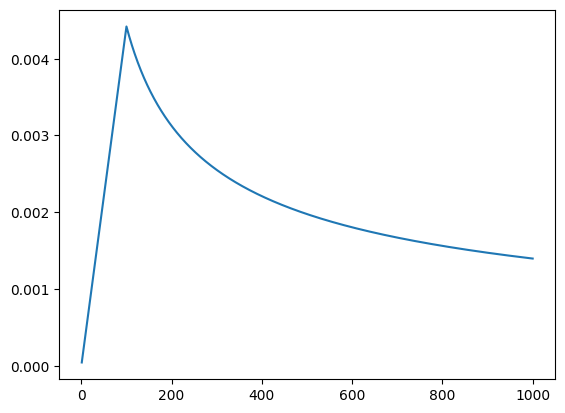

In [ ]:
def noam_decay(step, num_warmup_steps, dim):
  # Eq. (3) of the Transfomer paper.
  return (dim ** (-0.5) * min(step ** (-0.5), step * num_warmup_steps**(-1.5)))

plt.plot([step + 1 for step in range(1000)], [noam_decay(step + 1, 100, 512) for step in range(1000)])
plt.show()

We'll use Noam to be consistent with the paper, but other schedules are found to be roughly as effective as long as the learning rate "warms up" in the beginning and "cools down" later. See [here](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#schedules) for other schedules. For instance, linear decay looks like this.

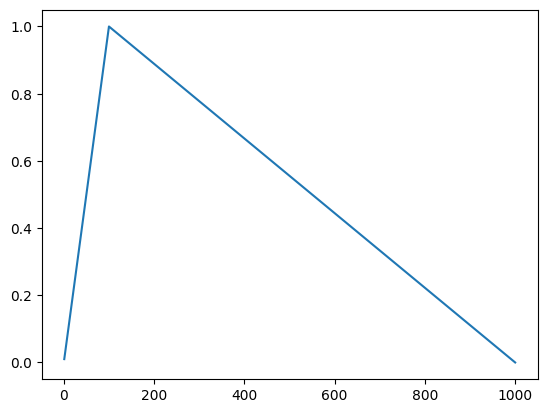

In [ ]:
def linear_decay(step, num_warmup_steps, num_training_steps):
  if step < num_warmup_steps:
    return float(step) / float(max(1, num_warmup_steps))
  else:
    return float(num_training_steps - step) / float(max(1, num_training_steps - num_warmup_steps))

plt.plot([step + 1 for step in range(1000)], [linear_decay(step + 1, 100, 1000) for step in range(1000)])
plt.show()

We also need an explicit initialization scheme based on Glorot / fan average / Xavier uniform.

In [ ]:
def init_parameters_xavier_uniform(model):
  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)

# Synthetic Task

The above model is ready to be trained and has been verified to yield competitive MT performance. However, even with this efficient GPU implementation training a Transformer encoder-decoder model on a real-world parallel corpus needs enough data and takes a while to get meaningful test time BLEU scores (at least a few hours). Thus we will limit our scope to a controllable synthetic task. Here is a data generator that represents a population distribution over source-target sequence pairs.

In [ ]:
from torch.nn.utils.rnn import pad_sequence


class Population:

  def __init__(self, vocab_size, min_length=4, max_length=20, transform='reverse'):
    assert vocab_size > 2  # Will reserve 0, 1, 2 for special symbols
    self.vocab_size = vocab_size
    self.min_length = min_length
    self.max_length = max_length
    self.transform = transform
    self.index_pad = 0
    self.index_bos = 1
    self.index_eos = 2
    self.vocab_regular = [x for x in range(3, vocab_size)]

  def sample(self, num_samples, device=None, min_length=-1, max_length=-1):
    # No need to pad source sequences with BOS/EOS
    min_length = self.min_length if min_length < 0 else min_length
    max_length = self.max_length if max_length < 0 else max_length
    source = [[random.choice(self.vocab_regular) for _ in range(random.randint(min_length, max_length))] for _ in range(num_samples)]
    lengths_source = torch.tensor([len(sequence) for sequence in source])

    # Pad target sequences with BOS/EOS
    if self.transform == 'reverse':
      target = [[self.index_bos] + list(reversed(sequence)) + [self.index_eos] for sequence in source]
    elif self.transform == 'sort':
      target = [[self.index_bos] + list(set(sorted(sequence))) + [self.index_eos] for sequence in source]
    else:
      raise NotImplementedError('Unknown trasnform', self.transform)
    lengths_target = torch.tensor([len(sequence) for sequence in target])

    # Batchfy sequences with padding
    source = pad_sequence([torch.tensor(sequence) for sequence in source], batch_first=True, padding_value=self.index_pad)
    target = pad_sequence([torch.tensor(sequence) for sequence in target], batch_first=True, padding_value=self.index_pad)

    if device is not None:
      source = source.to(device)
      target = target.to(device)
      lengths_source = lengths_source.to(device)
      lengths_target = lengths_target.to(device)

    return source, target, lengths_source, lengths_target

  def extract_sequence(self, padded_sequence):
    sequence = []
    for i in range(1, len(padded_sequence)):  # Ignore BOS
      if padded_sequence[i] == self.index_eos:
        break
      sequence.append(padded_sequence[i])
    return sequence

  def sequence_acc(self, padded_sequences_gold, padded_sequences_pred):
    """For evaluation we will consider sequence-level accuracy."""
    return sum([1 if self.extract_sequence(padded_sequences_gold[i]) == self.extract_sequence(padded_sequences_pred[i]) else
                0 for i in range(len(padded_sequences_gold))]) / len(padded_sequences_gold) * 100.


pop = Population(13, min_length=8, max_length=12)
source, target, lengths_source, lengths_target = pop.sample(4)
print('Source')
print(source)
print('Source lengths:', lengths_source.tolist())
print('Target')
print(target)
print('Target lengths:', lengths_target.tolist())

Source
tensor([[ 3,  7,  6,  6,  5,  4, 11,  4,  0,  0,  0,  0],
        [ 9,  3,  3,  4,  6,  6, 11, 12,  3, 11,  6, 11],
        [ 6, 10, 12,  7,  3,  5,  9,  8,  7,  5,  6,  0],
        [ 4,  4,  9,  4,  8,  8, 12,  7,  3, 10,  0,  0]])
Source lengths: [8, 12, 11, 10]
Target
tensor([[ 1,  4, 11,  4,  5,  6,  6,  7,  3,  2,  0,  0,  0,  0],
        [ 1, 11,  6, 11,  3, 12, 11,  6,  6,  4,  3,  3,  9,  2],
        [ 1,  6,  5,  7,  8,  9,  5,  3,  7, 12, 10,  6,  2,  0],
        [ 1, 10,  3,  7, 12,  8,  8,  4,  9,  4,  4,  2,  0,  0]])
Target lengths: [10, 14, 13, 12]


To get predictions we'll implement greedy decoding. The model predicts the most likely word conditioning on previous predictions *fixed*, and repeats this for a given number of steps.

In [ ]:
def decode_greedy(model, indices_source, max_length, index_bos):
  source = indices_source
  mask_source = None
  targets = [source.new_full((source.size(0), 1), index_bos)]

  for step in range(max_length):
    # source is re-written to be precomputed encoder embeddings.
    _, logits, source, mask_source, _, _, _ = model(source, targets[-1], step=step, mask_source=mask_source)
    _, indices_next = torch.max(logits, dim=-1)
    targets.append(indices_next.unsqueeze(1))

  return torch.cat(targets, dim=1)

We now fit the model on the synthetic population distribution.

In [ ]:
def fit(vocab_size=13, min_length=8, max_length=12, num_val_samples=1000, transform='reverse',
        dim=512, num_heads=4, dim_hidden=2048, num_layers=2, drop_rate=0.1, label_smoothing=0, num_epochs=10, batch_size=128,
        num_warmup_steps=1000, num_batches_per_epoch=60):
  set_seed(42)
  device = torch.device('cuda')
  pop = Population(vocab_size, min_length=min_length, max_length=max_length, transform=transform)
  source_val, target_val, _, _ = pop.sample(num_val_samples, device=device)  # Validation set
  source_ex = torch.tensor([[x for x in range(3, min(vocab_size, 10))]]).to(device)  # Running example
  model = TransformerSeq2Seq(vocab_size, dim, num_heads, dim_hidden, num_layers, drop_rate, pop.index_pad, label_smoothing).to(device)

  # Important!
  init_parameters_xavier_uniform(model)

  optimizer = Optimizer(model, 1., betas=(0.9, 0.98), eps=1e-9, decay_function='noam', num_warmup_steps=num_warmup_steps, dim=dim)

  for epoch in range(1, num_epochs + 1):
    model.train()
    loss_total = 0.
    num_predictions_total = 0

    for step in range(num_batches_per_epoch):
      source, target, _, lengths_target = pop.sample(batch_size, device=device)
      num_predictions = sum([lengths_target[i] - 1 for i in range(len(lengths_target))])
      loss_batch_total = model.forward(source.to(device), target.to(device))[0]
      loss_total += loss_batch_total.item()
      num_predictions_total += num_predictions
      loss_batch_avg = loss_batch_total / num_predictions
      loss_batch_avg.backward()

      optimizer.step()
      optimizer.zero_grad()

    model.eval()
    preds = decode_greedy(model, source_val, max_length + 1, pop.index_bos)
    pred_ex = decode_greedy(model, source_ex, max_length + 1, pop.index_bos)
    print('End of epoch {:3d} | epoch average loss {:8.4f} | val acc {:5.2f} | running ex {:s} -> {:s}'.format(
          epoch, loss_total / num_predictions_total, pop.sequence_acc(target_val.tolist(), preds.tolist()),
          str(source_ex[0].tolist()), str(pop.extract_sequence(pred_ex[0].tolist()))))

  return model, pop

In [ ]:
set_seed(42)
model, pop = fit(vocab_size=13, min_length=6, max_length=12, num_epochs=5, transform='reverse')

End of epoch   1 | epoch average loss   8.5649 | val acc  0.00 | running ex [3, 4, 5, 6, 7, 8, 9] -> [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
End of epoch   2 | epoch average loss   2.4811 | val acc  0.00 | running ex [3, 4, 5, 6, 7, 8, 9] -> [5, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
End of epoch   3 | epoch average loss   1.7679 | val acc  1.20 | running ex [3, 4, 5, 6, 7, 8, 9] -> [9, 8, 7, 5, 6, 3, 4]
End of epoch   4 | epoch average loss   0.9013 | val acc 23.40 | running ex [3, 4, 5, 6, 7, 8, 9] -> [9, 8, 7, 6, 5, 4, 3]
End of epoch   5 | epoch average loss   0.5440 | val acc 61.60 | running ex [3, 4, 5, 6, 7, 8, 9] -> [9, 8, 7, 6, 5, 4, 3]


The explicit initialization scheme was important for this to work (trying optimizing with default initialization instead). Does the model learn to attend as we expect? Let's look at the decoder's cross-attention weights. We have a $T' \times T$ attention map for each layer and each head.

source [12, 5, 6, 4, 7, 9, 4, 6, 9, 6, 11, 7]
target [1, 7, 11, 6, 9, 6, 4, 9, 7, 4, 6, 5, 12, 2]
prediction points [1, 7, 11, 6, 9, 6, 4, 9, 7, 4, 6, 5, 12]
Decoder cross-attention at layer 0


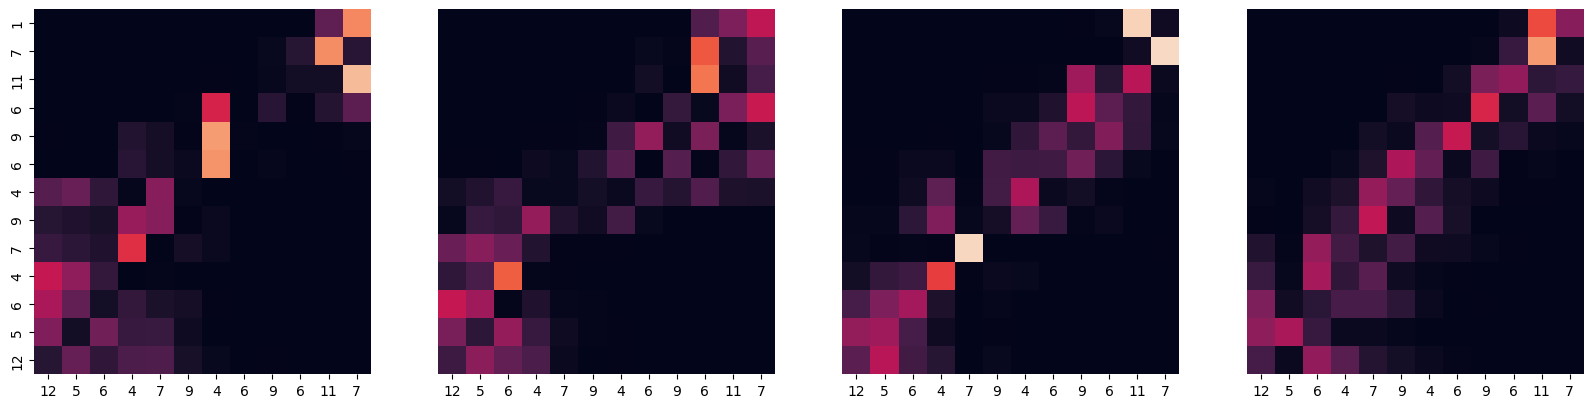

Decoder cross-attention at layer 1


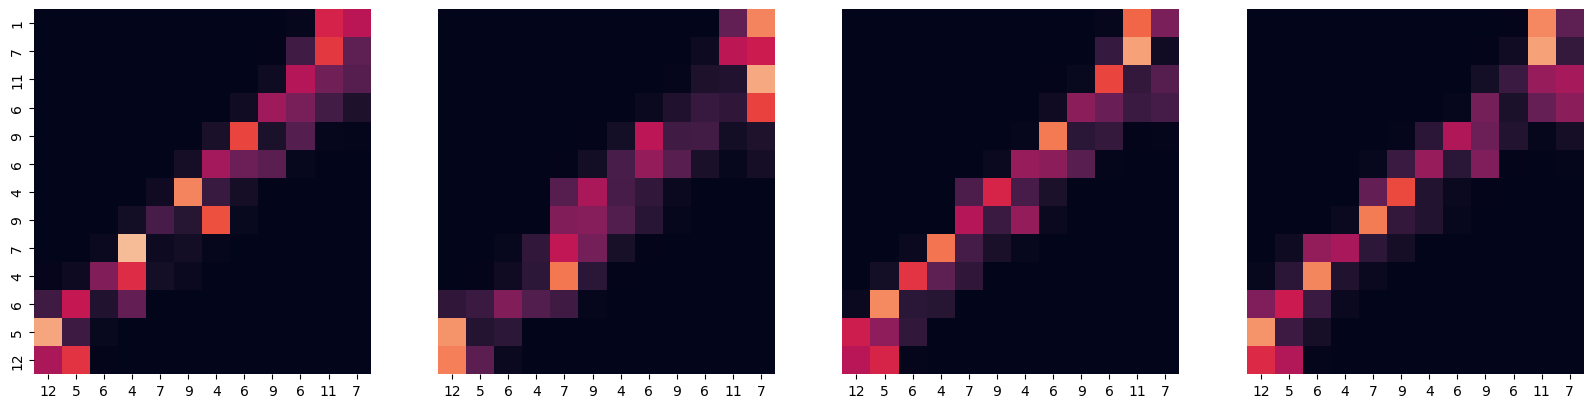

In [ ]:
source, target, _, _ = pop.sample(1, min_length=12, max_length=12, device=model.emb.weight.device)
_, _, _, _, self_attentions_encoder, self_attentions_decoder, cross_attentions_decoder = model.forward(source, target)

print('source {:s}'.format(str(source[0].tolist())))
print('target {:s}'.format(str(target[0].tolist())))
print('prediction points {:s}'.format(str(target[0,:-1].tolist())))
for layer in range(model.num_layers):
  fig, axs = plt.subplots(1, model.num_heads, figsize=(20, 10))
  print('Decoder cross-attention at layer {:d}'.format(layer))
  for head in range(model.num_heads):
    draw_attention(cross_attentions_decoder[layer][0, head].tolist(), source[0].tolist(), target[0,:-1].tolist() if head == 0 else [], ax=axs[head])
  plt.show()


We see that different heads learn different things, but they generally learn to pay attention to the right thing: namely, position $T-t$ in the source sequence when it needs to predict the $t$-th token (assuming reverse transform).

# Beam Search

Let's construct a test set.

In [ ]:
set_seed(7)
source_test, target_test, _, _ = pop.sample(1000, device=model.emb.weight.device)

Greedy decoding gets the following sequence-level accuracy.

In [ ]:
preds_test_greedy = decode_greedy(model, source_test, pop.max_length + 1, pop.index_bos)
acc_greedy = pop.sequence_acc(target_test.tolist(), preds_test_greedy.tolist())
print(acc_greedy)

62.6


Can we do better by beam search with beam size $>1$? Let's implement beam search. This is rather tricky, you may find referencing [this resource](https://github.com/pcyin/pytorch_basic_nmt/blob/75bafa2d05118a4e8a0e8691a986ab9dd09bb93d/nmt.py#L280) helpful, which is an implementation of beam search for RNNs.

In [ ]:
from collections import namedtuple


Hypothesis = namedtuple('Hypothesis', ['item', 'score'])


def beam_search_single(model, indices_source, beam_size, max_length, index_bos, index_eos):
  assert indices_source.dim() == 1  # Single sentence
  source = indices_source.unsqueeze(0)  # (1, length_source)
  mask_source = None
  remaining_hypotheses = [[index_bos]]
  remaining_scores = torch.zeros(len(remaining_hypotheses), 1).to(source.device)
  completed_hypotheses = []

  for step in range(max_length - 1):
    R = len(remaining_hypotheses)

    # Get last predictions: (R, 1) indices
    lasts = torch.tensor([hypothesis[-1] for hypothesis in remaining_hypotheses]).unsqueeze(-1).to(source.device)

    _, logits, source, mask_source, _, _, _ = model(source, lasts, step=step, mask_source=mask_source)

    # Turn logits (R, 1, V) to log probs and create R*V hypotheses.
    step_scores = logits.squeeze(1).log_softmax(dim=-1)  # (R, V)
    branched_scores = (remaining_scores.expand(-1, step_scores.size(-1)) + step_scores).view(-1)  # Computing branched scores by adding the expanded remaining scores to step scores, then flattening the result.
    assert branched_scores.dim() == 1 and branched_scores.size(0) == R * step_scores.size(1)  # R*V branchs' log probs

    # Choose K highest-scoring branches needed to complete search.
    K = beam_size - len(completed_hypotheses)
    topk_scores, indices_flat = torch.topk(branched_scores, k=K)

    # Which previous hypothesis is this branch continuing?
    prevs = torch.div(indices_flat, step_scores.size(-1), rounding_mode='floor')  # R*V ints in {0...R-1}

    # Which word is this branch outputting?
    words = indices_flat % step_scores.size(-1)  # R*V ints in {0...V-1}

    incomplete_hypotheses = []
    incomplete_scores = []
    incomplete_prevs = []

    # Backtrack origins of top-k scores to reconstruct new hypotheses.
    for prev, word, score in zip(prevs, words, topk_scores):
        new_hypothesis = remaining_hypotheses[prev] + [word.item()]
        if word.item() == index_eos:
            completed_hypotheses.append(Hypothesis(item=new_hypothesis, score=score.item()))
        else:
            incomplete_hypotheses.append(new_hypothesis)
            incomplete_scores.append(score.item())
            incomplete_prevs.append(prev)

    if len(completed_hypotheses) == beam_size:
        break

    incomplete_scores = torch.tensor(incomplete_scores).unsqueeze(dim=-1).to(source.device)
    incomplete_prevs = torch.tensor(incomplete_prevs).to(source.device)

    # Update beam. By design, beam elements sorted in decreasing score.
    remaining_hypotheses = incomplete_hypotheses  # K
    remaining_scores = incomplete_scores  # (K, 1)

    # Realign decoder's cached states to match new hypotheses. See remap_cache.
    model.decoder.remap_cache(incomplete_prevs)

    # Source-side realigning is done for you as an example.
    source = source.index_select(0, incomplete_prevs)

  # No hypothesis completed given length, will return the top (unfinished).
  if len(completed_hypotheses) == 0:
    completed_hypotheses.append(Hypothesis(item=remaining_hypotheses[0], score=remaining_scores[0].item()))

  # Sort completed hypotheses in decreasing score.
  completed_hypotheses.sort(key=lambda h: h.score, reverse=True)

  return [h.item for h in completed_hypotheses]


def beam_search(model, indices_source, beam_size, max_length, index_bos, index_eos):
  best_hypotheses = []
  for i in range(indices_source.size(0)):
    topk_hypotheses = beam_search_single(model, indices_source[i, :], beam_size, max_length, index_bos, index_eos)
    best_hypotheses.append(topk_hypotheses[0])
  return best_hypotheses

In [ ]:
for beam_size in [1, 2, 3, 4]:
  preds_test_beam = beam_search(model, source_test, beam_size, pop.max_length + 1, pop.index_bos, pop.index_eos)
  acc_beam = pop.sequence_acc(target_test.tolist(), preds_test_beam)
  print('beam_size={:d}: {:5.2f}'.format(beam_size, acc_beam))

beam_size=1: 63.00
beam_size=2: 65.40
beam_size=3: 65.00
beam_size=4: 64.70


TODO: Fill the table below and boldface the best accuracy.

| Search Method     | Test Accuracy |
| :---:             | :---:         |
| Greedy            |         |
| Beam Search (Beam Size 1)   |  63.00      |
| Beam Search (Beam Size 2)   |  **65.40**     |
| Beam Search (Beam Size 3)   |  65.00      |
| Beam Search (Beam Size 4)   |  64.70      |



Assuming the model is not trained to perfection (i.e., it didn't get enough supervision to simply do greedy decoding and make correct predictions), we should see some improvement as we use beam size $>1$. A bigger beam size doesn't necessarily mean better performance, so it should be a hyperparameter to tune on validation performance.

# Appendix: Discussions

There are many other details that are beyond the scope of the assignment. You can take a look at serious implementations of the Transformer encoder-decoder model like the [huggingface implementation](https://huggingface.co/transformers/model_doc/bart.html) of [BART](https://arxiv.org/pdf/1910.13461.pdf).

Training a real-world MT model follows the same basic principles as in this synthetic setting. Here we discuss a few points not covered in this assignment.

In [ ]:
!pip install transformers
!pip install sacrebleu
import sacrebleu
from transformers import BartTokenizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 3.5 MB/s eta 0:00:00


**BPE tokenization**: It's become standard to use a pretrained BPE tokenizer (e.g., see [here](https://huggingface.co/transformers/tokenizer_summary.html)) to have language agnostic tokens. It already contains special symbols for padding, BOS, EOS. This way the embedding matrix can be shared between source and target languages.



In [ ]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
print('Vocab size', tokenizer.vocab_size)
print('PAD index', tokenizer.pad_token_id)
print('BOS index', tokenizer.bos_token_id)
print('EOS index', tokenizer.eos_token_id)

sent = "Naked I came from my morther's womb"
print('sent', sent)
print('tokenized', tokenizer.tokenize(sent))
print('tokenized (with BOS/EOS), indexed, truncated', tokenizer(sent, truncation=True, max_length=4, return_attention_mask=False)['input_ids'])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

Vocab size 50265
PAD index 1
BOS index 0
EOS index 2
sent Naked I came from my morther's womb
tokenized ['N', 'aked', 'ĠI', 'Ġcame', 'Ġfrom', 'Ġmy', 'Ġmort', 'her', "'s", 'Ġwomb']
tokenized (with BOS/EOS), indexed, truncated [0, 487, 8435, 2]


**Batching and multi-GPU training**: Batching is extremely important for efficient training. Because (target) sequences can have wildly different lengths, naive batching can be inefficient (imagine padding a batch with one sequence of length 1000 and other sequences of length 2). One can consider "bucket sampling", where we first sort (target) sequences in length and then create batches to contain sequences of similar length (then randomize the order of those batches). Training must be done in large scale in which there are tens or hundreds of thousands, or even millions, of token predictions per batch. This requires a multi-GPU implementation. This is now pretty easy to do with libraries like PyTorch (see [data parallel](https://pytorch.org/docs/stable/generated/torch.nn.DataParallel.html) and [distributed data parallel](https://pytorch.org/tutorials/intermediate/ddp_tutorial.html)).

**BLEU**: We can use convenient libraries like [sacrebleu](https://github.com/mjpost/sacrebleu) to compute the BLEU score correctly.

In [ ]:
hyps = ['The dog bit the man.', "It wasn't surprising.", 'The man had just bitten him.']
refs = [['The dog bit the man.', 'It was not unexpected.', 'The man bit him first.'],
        ['The dog had bit the man.', 'No one was surprised.', 'The man had bitten the dog.']]
bleu = sacrebleu.corpus_bleu(hyps, refs).score
print('{:5.2f}'.format(bleu))

48.53


**System combination**. It is well known that we can usually gain significant improvement simply by combining differently trained systems.

In a *single-model* combination, we can average the last few checkpoints of model parameters in training (e.g., the transformer paper averages the last 5 checkpoints for small models and 20 checkpoints for big models).

In a *multi-model* combination, we can train $k$ different models separately, possibly using different portions of data (i.e., bagging), and average prediction probabilities. Note that this requires $k$ times more memory and computation at test time.